In [117]:
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import pandas as pd
from bw2data import Database

In [118]:
bd.projects.set_current("paw_lca")
'paw_db' in bd.databases

True

In [119]:
paw_db = bd.Database('paw_db')

In [120]:
ef_gwp_key = [
    m for m in bd.methods if "climate change" == m[2] and "EF v3.1" == m[1]
].pop()
print(ef_gwp_key)

# We can look at the method details
ef_gwp_method = bd.Method(ef_gwp_key)
print(ef_gwp_method)

('ecoinvent-3.11', 'EF v3.1', 'climate change', 'global warming potential (GWP100)')
Brightway2 Method: ecoinvent-3.11: EF v3.1: climate change: global warming potential (GWP100)


In [121]:
fu = bd.get_node(id=247038522800988161)
fu

'sludge incineration' (kilogram, Europe without Switzerland, None)

In [122]:
my_functional_unit, data_objs, _ = bd.prepare_lca_inputs(
    {fu: 1}, method=ef_gwp_key,
)
my_lca = bc.LCA(demand=my_functional_unit, data_objs=data_objs)
my_lca.lci()
my_lca.lcia()
my_lca.score

-0.08693584089052496

### from here multi-lca

In [82]:
for act in paw_db:
    print(act)


'transport of sludge to incineration' (ton kilometer, RER, None)
'transport of fertilizer to soil' (ton kilometer, RER, None)
'Chemicals 230' (cubic meter, RER, None)
'GAC 230' (cubic meter, RER, None)
'Electricity 102' (cubic meter, RER, None)
'Chemicals 128' (cubic meter, RER, None)
'Emissions 230' (cubic meter, RER, None)
'Chemicals 102' (cubic meter, RER, None)
'secondary treatment' (cubic meter, Europe without Switzerland, None)
'Electricity 230' (cubic meter, RER, None)
'sludge incineration' (kilogram, Europe without Switzerland, None)


In [83]:
ef_methods = list(filter(lambda x: "EF v3.1 no LT" in x[1], list(bd.methods)))
print("We have", len(ef_methods), "EF v3.1 no LT methods we will evaluate.")

We have 25 EF v3.1 no LT methods we will evaluate.


In [97]:
for act in paw_db:
    print(act["code"])

sec_tre
trans_sldg_to_inc
trans_fer_to_soi
102_elec
128_chem
230_elec
230_chem
230_em
inc
102_chem
230_gac


In [101]:
all_acts_fu = {act["code"]: {act.id: 1.0} for act in paw_db}
print(f"Functional units for {paw_db}: {all_acts_fu}")

config_1 = {"impact_categories": ef_methods}

print(
        f"Testing LCIA with all activities in database '{paw_db}': {len(all_acts_fu)} activities")

Functional units for Brightway2 SQLiteBackend: paw_db: {'230_chem': {247038522792599552: 1.0}, '230_gac': {247038522725490689: 1.0}, 'trans_fer_to_soi': {247038522800988164: 1.0}, 'trans_sldg_to_inc': {247038522800988163: 1.0}, '102_elec': {247038522792599554: 1.0}, 'inc': {247038522800988161: 1.0}, '230_elec': {247038522725490688: 1.0}, '102_chem': {247038522792599555: 1.0}, '128_chem': {247038522800988160: 1.0}, 'sec_tre': {247038522800988162: 1.0}, '230_em': {247038522792599553: 1.0}}
Testing LCIA with all activities in database 'Brightway2 SQLiteBackend: paw_db': 11 activities


In [104]:
all_acts_data_objs = bd.get_multilca_data_objs(
            functional_units=all_acts_fu, method_config=config_1
        )
all_acts_mlca = bc.MultiLCA(
    demands=all_acts_fu, method_config=config_1, data_objs=all_acts_data_objs
        )
all_acts_mlca.lci()
all_acts_mlca.lcia()
print("Results for all activities in database generated")

Results for all activities in database generated


In [107]:
dfresults = pd.DataFrame.from_dict(all_acts_mlca.scores, orient='index')
dfresults.index = pd.MultiIndex.from_tuples(dfresults.index, names=['Column', 'Row'])
dfresults = dfresults.unstack(level=0)

dfresults

0  \
Column            (ecoinvent-3.11, EF v3.1 no LT, acidification no LT, accumulated exceedance (AE) no LT)   
Row                                                                                                         
102_chem                                                    0.000267                                        
102_elec                                                    0.000277                                        
128_chem                                                    0.002396                                        
230_chem                                                    0.002106                                        
230_elec                                                    0.000376                                        
230_em                                                           NaN                                        
230_gac                                                          NaN                                        
inc                                                        -0.000469                                        
sec_tre                                                    -0.001736                                        
trans_fer_to_soi                                            0.069196                                        
trans_sldg_to_inc                                           0.069196                                        

                                                                                                                  \
Column            (ecoinvent-3.11, EF v3.1 no LT, climate change no LT, global warming potential (GWP100) no LT)   
Row                                                                                                                
102_chem                                                    0.053831                                               
102_elec                                                    0.055952                                               
128_chem                                                    0.133521                                               
230_chem                                                    0.319085                                               
230_elec                                                    0.076028                                               
230_em                                                           NaN                                               
230_gac                                                          NaN                                               
inc                                                        -0.086936                                               
sec_tre                                                    -0.334391                                               
trans_fer_to_soi                                           15.050202                                               
trans_sldg_to_inc                                          15.050202                                               

                                                                                                                            \
Column            (ecoinvent-3.11, EF v3.1 no LT, climate change: biogenic no LT, global warming potential (GWP100) no LT)   
Row                                                                                                                          
102_chem                                                    0.000111                                                         
102_elec                                                    0.000116                                                         
128_chem                                                    0.000758                                                         
230_chem                                                    0.000408                                                         
230_elec                                                    0.000158  

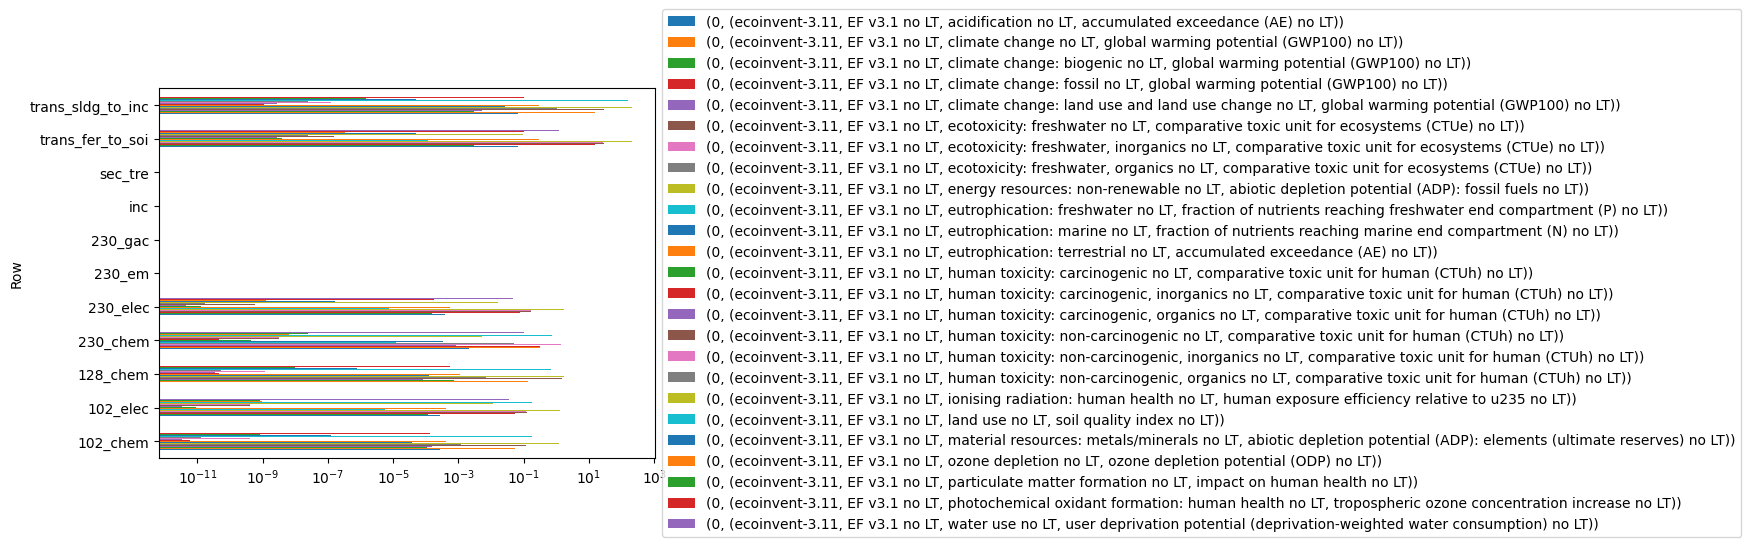

In [116]:

import matplotlib.pyplot as plt

dfresults.plot(kind="barh")
ax = plt.subplot(111)
plt.xscale("log")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height, box.width, box.height])
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [102]:
fu_one = "transport of sludge to incineration"
fu_two = 'transport of fertilizer to soil'

paw_db.get(name=fu_one).id

247038522800988163

In [90]:
fu_one = 'transport of sludge to incineration'
fu_two = 'transport of fertilizer to soil'

functional_units_2 = {
    "Act_1": {paw_db.get(fu_one).id: 1},
    "Act_2": {paw_db.get(fu_two).id: 1},
}
config_2 = {
    "impact_categories": ef_methods
}
data_objs_2 = bd.get_multilca_data_objs(functional_units=functional_units_2, method_config=config_2)

UnknownObject: 

In [70]:
fu_list = []

for node in paw_db:
    fu_list.append(node)
    

fu_list[0].get

<bound method Mapping.get of 'Chemicals 102' (cubic meter, RER, None)>

In [38]:
fu_list = []

for node in paw_db:
    fu_list.append(node)

fu_list[0]

for unit in fu_list:
        print(unit: {paw_db.get(unit).id: 1})

SyntaxError: invalid syntax (528404089.py, line 9)

In [48]:
for unit in paw_db:
    print(unit[1])

230_gac
sec_tre
102_chem
230_em
128_chem
102_elec
trans_fer_to_soi
230_chem
inc
trans_sldg_to_inc
230_elec


In [43]:
for unit in paw_db:
   print(unit[0]: {wb.get(unit).id: 1})

SyntaxError: invalid syntax (3997508766.py, line 2)

In [73]:
for unit in fu_list:
        unit.get: {unit.id: 1}

In [71]:
functional_units = {
    for unit in fu_list:
        unit.get: {unit.id: 1},
}
config_2 = {
    "impact_categories": ef_methods
}
data_objs_2 = bd.get_multilca_data_objs(functional_units=functional_units_2, method_config=config_2)

SyntaxError: invalid syntax (1736200165.py, line 2)

In [16]:
for unit in functional_unit:
        print({unit: 1})

{'secondary treatment' (cubic meter, Europe without Switzerland, None): 1}
{'transport of fertilizer to soil' (ton kilometer, RER, None): 1}
{'transport of sludge to incineration' (ton kilometer, RER, None): 1}
{'Chemicals 128' (cubic meter, RER, None): 1}
{'sludge incineration' (kilogram, Europe without Switzerland, None): 1}
{'Electricity 230' (cubic meter, RER, None): 1}
{'GAC 230' (cubic meter, RER, None): 1}
{'Chemicals 230' (cubic meter, RER, None): 1}
{'Chemicals 102' (cubic meter, RER, None): 1}
{'Electricity 102' (cubic meter, RER, None): 1}
{'Emissions 230' (cubic meter, RER, None): 1}
